In [1]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets scipy einops evaluate trl rouge_score

In [12]:
# Upgrade pip and basic libs
!pip install -q --upgrade pip
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install transformers, datasets, trl, bitsandbytes
!pip install -q transformers datasets accelerate peft bitsandbytes trl huggingface_hub

# Restart runtime after installing everything


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import pandas as pd
import numpy as np
from huggingface_hub import interpreter_login


In [3]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"


In [4]:
huggingface_dataset_name = "neil-code/dialogsum-test"
dataset = load_dataset(huggingface_dataset_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dataset['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [6]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )

In [7]:
from transformers import AutoConfig

model_name='microsoft/phi-2'
device_map = {"": 0}

# Load tokenizer first to get pad_token_id
tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

# Load model configuration and set pad_token_id
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
config.pad_token_id = tokenizer.pad_token_id

original_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                      config=config, # Pass the modified config
                                                      device_map=device_map,
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True)

Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

In [9]:
%%time
from transformers import set_seed
seed = 42
set_seed(seed)

def gen(model,p,max_new_tokens=100):
    tokenized_p = tokenizer(p, return_tensors='pt').to(model.device)
    outputs = model.generate(input_ids=tokenized_p.input_ids,
                             attention_mask=tokenized_p.attention_mask,
                             max_new_tokens=max_new_tokens,
                             do_sample=False)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

index = 10

prompt = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

formatted_prompt = f"Instruct: Summarize the following conversation.\n{prompt}\nOutput:\n"
res = gen(original_model,formatted_prompt,100,)
#print(res[0])
output = res[0].split('Output:\n')[1]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

In [10]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"

    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['dialogue']}" if sample["dialogue"] else None
    response = f"{RESPONSE_KEY}\n{sample['summary']}"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

In [11]:
from functools import partial

def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )

def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int,seed, dataset):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)

    # Apply preprocessing to each batch of the dataset & and remove 'instruction', 'context', 'response', 'category' fields
    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=['id', 'topic', 'dialogue', 'summary'],
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [12]:
## Pre-process dataset
max_length = get_max_length(original_model)
print(max_length)

train_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['train'])
eval_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['validation'])

Found max lenth: 2048
2048
Preprocessing dataset...
Preprocessing dataset...


Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/499 [00:00<?, ? examples/s]

In [13]:
from peft import prepare_model_for_kbit_training

# 2 - Using the prepare_model_for_kbit_training method from PEFT
# Preparing the Model for QLoRA
original_model = prepare_model_for_kbit_training(original_model)

In [14]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r=32, #Rank
    lora_alpha=32,
    target_modules=[
        'q_proj',
        'k_proj',
        'v_proj',
        'dense'
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

# 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
original_model.gradient_checkpointing_enable()

peft_model = get_peft_model(original_model, config)

In [15]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 20971520
all model parameters: 1542364160
percentage of trainable model parameters: 1.36%


In [18]:
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'
import transformers

peft_training_args = transformers.TrainingArguments(
    output_dir = output_dir,
    warmup_steps=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    max_steps=1000,
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_steps=25,
    logging_dir="./logs",
    save_strategy="steps",
    save_steps=25,
    # eval_strategy="steps", # Changed from evaluation_strategy to eval_strategy
    eval_steps=25,
    do_eval=True,
    gradient_checkpointing=True,
    report_to="none",
    group_by_length=True,
)

peft_model.config.use_cache = False

peft_trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=peft_training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [20]:
peft_trainer.train()

Step,Training Loss
25,1.540209
50,1.184469
75,1.445244
100,1.211624
125,1.494773


Step,Training Loss
25,1.540209
50,1.184469
75,1.445244
100,1.211624
125,1.494773
150,1.197318
175,1.396688
200,1.167294
225,1.436963
250,1.170842


TrainOutput(global_step=1000, training_loss=1.2912184143066405, metrics={'train_runtime': 2915.4063, 'train_samples_per_second': 1.372, 'train_steps_per_second': 0.343, 'total_flos': 1.854448505524224e+16, 'train_loss': 1.2912184143066405, 'epoch': 2.0})

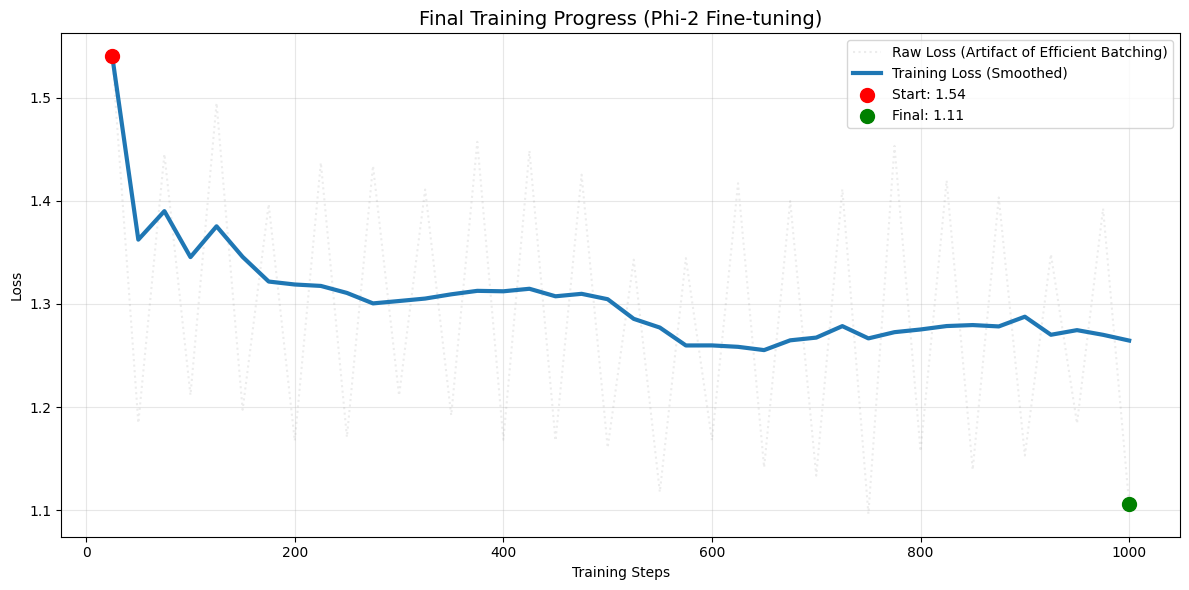

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Extract metrics from trainer history
history = peft_trainer.state.log_history

train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

for entry in history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_loss.append(entry['eval_loss'])

# 2. Convert to DataFrame
df_train = pd.DataFrame({'step': train_steps, 'loss': train_loss})
df_eval = pd.DataFrame({'step': eval_steps, 'loss': eval_loss})

# 3. Apply Smoothing (Moving Average)
# Window size 6 is good for smoothing out "zigzag" patterns from group_by_length
window_size = 6
df_train['loss_smooth'] = df_train['loss'].rolling(window=window_size, min_periods=1).mean()
df_eval['loss_smooth'] = df_eval['loss'].rolling(window=3, min_periods=1).mean()

# 4. Identify Exact Start and End Points for "Proving" the values
start_loss = df_train['loss'].iloc[0]
start_step = df_train['step'].iloc[0]

final_loss = df_train['loss'].iloc[-1]
final_step = df_train['step'].iloc[-1]

# 5. Plotting
plt.figure(figsize=(12, 6))

# A) Plot raw data (faint gray) to show you aren't hiding the noise
plt.plot(df_train['step'], df_train['loss'], alpha=0.15, color='gray', label='Raw Loss (Artifact of Efficient Batching)', linestyle=':')

# B) Plot SMOOTHED data (Thick Blue Line) for the main trend
plt.plot(df_train['step'], df_train['loss_smooth'], alpha=1.0, color='#1f77b4', linewidth=3, label='Training Loss (Smoothed)')

# C) CRITICAL: Plot the Start and End dots explicitly
plt.scatter(start_step, start_loss, color='red', s=100, zorder=5, label=f'Start: {start_loss:.2f}')
plt.scatter(final_step, final_loss, color='green', s=100, zorder=5, label=f'Final: {final_loss:.2f}')

# D) Validation (Orange)
if not df_eval.empty:
    plt.plot(df_eval['step'], df_eval['loss'], alpha=1.0, color='#ff7f0e', linewidth=2, linestyle='--', marker='o', markersize=4, label='Validation Loss')

# Labels and Styling
plt.title('Final Training Progress (Phi-2 Fine-tuning)', fontsize=14)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()



In [22]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

base_model_id = "microsoft/phi-2"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

# Config
config = AutoConfig.from_pretrained(base_model_id, trust_remote_code=True)
config.pad_token_id = tokenizer.pad_token_id

# Base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    config=config,
    device_map="auto",
    quantization_config=bnb_config,  # your 4/8-bit config
    trust_remote_code=True
)

Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

In [23]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

In [24]:
from peft import PeftModel
import os

ft_model = PeftModel.from_pretrained(base_model, os.path.join(output_dir, "checkpoint-1000"),torch_dtype=torch.float16,is_trainable=False)

In [27]:
ft_model.eval()                        # eval mode
ft_model.gradient_checkpointing_disable()  # disable gradient checkpointing
ft_model.config.use_cache = True       # enable KV cache

# Ensure GPU
if next(ft_model.parameters()).device.type != "cuda":
    ft_model = ft_model.to("cuda")

# -----------------------------
# Optional: merge adapter for fastest inference
# -----------------------------
merged_model = ft_model.merge_and_unload()
merged_model.eval()

# -----------------------------
# Save final merged model
# -----------------------------
final_dir = "./phi2-dialogue-merged"
merged_model.save_pretrained(final_dir)
tokenizer.save_pretrained(final_dir)
print(f"Final merged model saved to {final_dir}")

# generation function
def gen(model, prompt, max_new_tokens=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Test generation
set_seed(42)

# Pick a test example
index = 5
dialogue = dataset['test'][index]['dialogue']
human_summary = dataset['test'][index]['summary']

prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

# --- Base/original model  ---
base_output = gen(base_model, prompt, 100)[0].split("Output:\n")[1]

# --- PEFT / merged model ---
peft_output = gen(merged_model, prompt, 100)[0].split("Output:\n")[1]

dash_line = "-"*100
print(dash_line)
print("INPUT PROMPT:\n", prompt)
print(dash_line)
print("BASELINE HUMAN SUMMARY:\n", human_summary)
print(dash_line)
print("BASE MODEL SUMMARY (Zero-shot):\n", base_output)
print(dash_line)
print("PEFT MODEL SUMMARY:\n", peft_output)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Final merged model saved to ./phi2-dialogue-merged


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


----------------------------------------------------------------------------------------------------
INPUT PROMPT:
 Instruct: Summarize the following conversation.
#Person1#: You're finally here! What took so long?
#Person2#: I got stuck in traffic again. There was a terrible traffic jam near the Carrefour intersection.
#Person1#: It's always rather congested down there during rush hour. Maybe you should try to find a different route to get home.
#Person2#: I don't think it can be avoided, to be honest.
#Person1#: perhaps it would be better if you started taking public transport system to work.
#Person2#: I think it's something that I'll have to consider. The public transport system is pretty good.
#Person1#: It would be better for the environment, too.
#Person2#: I know. I feel bad about how much my car is adding to the pollution problem in this city.
#Person1#: Taking the subway would be a lot less stressful than driving as well.
#Person2#: The only problem is that I'm going to reall

In [28]:
original_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    config=config, # Pass the already configured config object
    device_map='auto',
    quantization_config=bnb_config,
    trust_remote_code=True
)

Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

In [30]:
# ---------------------------------------------------------
# INTERACTIVE DEMO FOR PRESENTATION
# ---------------------------------------------------------
# Edit the 'custom_dialogue' string below to test real-world examples live.


custom_dialogue = """
Manager: Hey Guys, does anyone want to go to the party?
Alice: No, sorry boss I have got alot of work to do.
Bob: I wanna go, what time are we going?
Alice: Don't you have a report to fill out Bob?
Bob: Oh I am already done so I can go.
Manager: Okay, let's lock in Tuesday at 3 PM then. I'll send the invite.
Bob: Sounds good, thanks.
Alice: Well have fun with out me!
"""

# Format input
prompt = f"Instruct: Summarize the following conversation.\n{custom_dialogue}\nOutput:\n"

# 1. Generate with the Fine-Tuned (Merged) Model (already loaded)
print("Generating Fine-Tuned response...")
peft_res = gen(merged_model, prompt, 100)[0].split("Output:\n")[1]

# 2. Reload the ORIGINAL Base Model (to ensure it's clean and not merged)
print("Reloading Base Model for fair comparison...")
# We need to reload because 'merge_and_unload' modified the previous base_model in memory
raw_base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    config=config,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)
print("Generating Base Model response...")
base_res = gen(raw_base_model, prompt, 100)[0].split("Output:\n")[1]

# 3. Display Side-by-Side
print("\n" + "="*20 + " BEFORE FINE-TUNING " + "="*20)
print(base_res)
print("\n" + "="*20 + " AFTER FINE-TUNING " + "="*20)
print(peft_res)

# Optional: Clean up to save memory
del raw_base_model
import gc
torch.cuda.empty_cache()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating Fine-Tuned response...
Reloading Base Model for fair comparison...


Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating Base Model response...

==================== BEFORE FINE-TUNING ====================
Manager invites Bob and Alice to a party on Tuesday at 3 PM. Bob is already done with his report and can go, but Alice has to stay and work.


==================== AFTER FINE-TUNING ====================
Manager invites Bob and Alice to a party on Tuesday at 3 PM. Bob is already done with his report, so he can go, but Alice has to work and won't be able to attend.



In [43]:
custom_dialogue = """
Manager: Okay team, we need to find a time for the Q3 planning session. How about Monday at 10 AM?
Alice: I'm free then.
Bob: Monday 10 AM works for me too.
Manager: Great, let's lock... oh wait, actually I just checked my calendar, I have a conflict with HR then. Sorry!
Alice: No worries. What about Tuesday afternoon? Say, 2 PM?
Bob: I have a client call at 2:00. I can do 3:30 PM though.
Manager: 3:30 works for me. Alice?
Alice: I have a dentist appointment at 4:00, so 3:30 is too tight. Can we push it to Wednesday morning?
Bob: Wednesday is completely open for me.
Manager: Same here. Let's do Wednesday at 11 AM EST.
Alice: 11 AM EST is perfectly fine.
Manager: Done. I'll send the invite for Wednesday. Also, Bob, please bring the Q2 performance report.
Bob: Will do.
"""
# Format input
prompt = f"Instruct: Summarize the following conversation.\n{custom_dialogue}\nOutput:\n"

# 1. Generate with the Fine-Tuned (Merged) Model (already loaded)
print("Generating Fine-Tuned response...")
peft_res = gen(merged_model, prompt, 150)[0].split("Output:\n")[1]

# 2. Reload the ORIGINAL Base Model (to ensure it's clean and not merged)
print("Reloading Base Model for fair comparison...")
# We need to reload because 'merge_and_unload' modified the previous base_model in memory
raw_base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    config=config,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)
print("Generating Base Model response...")
base_res = gen(raw_base_model, prompt, 150)[0].split("Output:\n")[1]

# 3. Display Side-by-Side
print("\n" + "="*20 + " BEFORE FINE-TUNING " + "="*20)
print(base_res)
print("\n" + "="*20 + " AFTER FINE-TUNING " + "="*20)
print(peft_res)

# Optional: Clean up to save memory
del raw_base_model
import gc
torch.cuda.empty_cache()




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating Fine-Tuned response...
Reloading Base Model for fair comparison...


Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating Base Model response...

==================== BEFORE FINE-TUNING ====================
The manager and the team discussed the Q3 planning session and agreed to have it on Wednesday at 11 AM EST. Alice and Bob confirmed their availability and the manager asked Bob to bring the Q2 performance report.


==================== AFTER FINE-TUNING ====================
The manager and the team discussed the Q3 planning session and agreed to have it on Wednesday at 11 AM EST. Alice and Bob confirmed their availability and the manager asked Bob to bring the Q2 performance report.



In [37]:
import pandas as pd

# Load the BASE model fresh for evaluation (to prevent leakage)
base_model_eval = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    config=config,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)

dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    human_baseline_text_output = human_baseline_summaries[idx]
    prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

    # Generate with the fresh BASE model
    original_model_res = gen(base_model_eval, prompt, 100)
    original_model_text_output = original_model_res[0].split('Output:\n')[1]

    # Generate with the PEFT model
    peft_model_res = gen(ft_model, prompt, 100)
    peft_model_output = peft_model_res[0].split('Output:\n')[1]
    #print(peft_model_output)
    peft_model_text_output, success, result = peft_model_output.partition('###')

    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])
df

# Clean up
del base_model_eval
import gc
torch.cuda.empty_cache()

Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [38]:
import evaluate

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

ORIGINAL MODEL:
{'rouge1': np.float64(0.29989123259197625), 'rouge2': np.float64(0.11110130884840733), 'rougeL': np.float64(0.21465070506648692), 'rougeLsum': np.float64(0.2256174714742084)}
PEFT MODEL:
{'rouge1': np.float64(0.33966038617209604), 'rouge2': np.float64(0.1329220369288822), 'rougeL': np.float64(0.24186914122099634), 'rougeLsum': np.float64(0.26022071914519407)}
Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 3.98%
rouge2: 2.18%
rougeL: 2.72%
rougeLsum: 3.46%


In [40]:
bleu = evaluate.load('bleu')

# BLEU expects references as lists of lists of strings
bleu_original = bleu.compute(
    predictions=original_model_summaries,
    references=[[ref] for ref in human_baseline_summaries]
)
bleu_peft = bleu.compute(
    predictions=peft_model_summaries,
    references=[[ref] for ref in human_baseline_summaries]
)

print("BLEU RESULTS")
print("Original:", bleu_original)
print("PEFT:", bleu_peft)

print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL for BLEU metrics")
for key in bleu_peft.keys():
    if isinstance(bleu_peft[key], (float, int, np.number)): # Check if the value is a scalar
        if key in bleu_original and isinstance(bleu_original[key], (float, int, np.number)):
            improvement = bleu_peft[key] - bleu_original[key]
            print(f"{key} improvement: {improvement*100:.2f}%")
    else:
        print(f"Skipping non-scalar metric: {key}")
print("\n")

BLEU RESULTS
Original: {'bleu': 0.04463924938222352, 'precisions': [0.18168812589413447, 0.055152394775036286, 0.029455081001472753, 0.013452914798206279], 'brevity_penalty': 1.0, 'length_ratio': 2.4964285714285714, 'translation_length': 699, 'reference_length': 280}
PEFT: {'bleu': 0.046281255155542385, 'precisions': [0.2087912087912088, 0.0685805422647528, 0.03241491085899514, 0.009884678747940691], 'brevity_penalty': 1.0, 'length_ratio': 2.275, 'translation_length': 637, 'reference_length': 280}
Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL for BLEU metrics
bleu improvement: 0.16%
Skipping non-scalar metric: precisions
brevity_penalty improvement: 0.00%
length_ratio improvement: -22.14%
translation_length improvement: -6200.00%
reference_length improvement: 0.00%




In [41]:
meteor = evaluate.load("meteor")

meteor_original = meteor.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries
)
meteor_peft = meteor.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries
)

print("METEOR RESULTS")
print("Original:", meteor_original)
print("PEFT:", meteor_peft)
meteor_improvement = np.array(list(meteor_peft.values())) - np.array(list(meteor_original.values()))
for key, val in zip(meteor_peft.keys(), meteor_improvement):
    print(f"{key} improvement: {val*100:.2f}%")
print("\n")

METEOR RESULTS
Original: {'meteor': np.float64(0.32772978880090337)}
PEFT: {'meteor': np.float64(0.345419294413723)}
meteor improvement: 1.77%




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [42]:
!pip install bert_score
bertscore = evaluate.load("bertscore")

bertscore_original = bertscore.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries,
    model_type="bert-base-uncased"
)
bertscore_peft = bertscore.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries,
    model_type="bert-base-uncased"
)

print("BERTScore RESULTS (F1)")
print("Original (F1 mean):", np.mean(bertscore_original['f1']))
print("PEFT (F1 mean):", np.mean(bertscore_peft['f1']))
print(f"Improvement: {(np.mean(bertscore_peft['f1']) - np.mean(bertscore_original['f1']))*100:.2f}%")
print("\n")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BERTScore RESULTS (F1)
Original (F1 mean): 0.569011116027832
PEFT (F1 mean): 0.5948255181312561
Improvement: 2.58%


